In [1]:
import torch.nn as nn
import torch
from torch.optim import Adam

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [3]:
import gymnasium as gym

In [4]:
class DQN(nn.Module):

    def __init__(self, n_states, n_actions):
        super().__init__()
        self.n_states = n_states
        self.n_actions = n_actions

        self.network = nn.Sequential(
            nn.Linear(self.n_states, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, self.n_actions)
        )

    def forward(self, states):
        return self.network(states)


In [5]:
class ReplayBuffer:
    
    def __init__(self, size=20000):
        self.size = size
        self.buffer = []
        self.next_id = 0


    def __len__(self):
        return len(self.buffer)
    

    def add(self, state, action, reward, next_state, done):
        item = (state, action, reward, next_state, done)
        if len(self.buffer) < self.size:
            self.buffer.append(item)
        else:
            self.buffer[self.next_id] = item
        self.next_id = (self.next_id + 1) % self.size


    def sample(self, batch_size):
        idx = np.random.choice(len(self.buffer), batch_size)
        samples = [self.buffer[i] for i in idx]
        return list(zip(*samples))

In [62]:
class Agent:

    def __init__(self,env, n_states, n_actions, gamma=0.9, episilon = 1, episilon_decay = 0.997, episilon_min = 0.01):
        
        self.env = env
        self.n_states = n_states
        self.n_actions = n_actions
        
        self.gamma = gamma
        self.episilon = episilon
        self.episilon_decay = episilon_decay
        self.episilon_min = episilon_min
        self.steps = 0
        self.target_update_freq = 100
        self.batch_size = 64

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.policy_net = DQN(n_states, n_actions)
        self.policy_net.to(self.device)
        self.target_net = DQN(n_states, n_actions)
        self.target_net.to(self.device)
        self.buffer = ReplayBuffer()

        self.policy_net.to(self.device)
        self.target_net.to(self.device)

        self.optimizer = Adam(self.policy_net.parameters(), lr = 0.0001)
        self.loss = nn.MSELoss()
        self.addMemory()
        
    
    def addMemory(self):
        sum_rewards = 0
        state = self.env.reset()[0]
        for _ in range(1000):

            action = self.env.action_space.sample()
            next_state, reward, term, trun, _ = self.env.step(action)
            done = int(term or trun)
            sum_rewards += 1
            self.buffer.add(state, action, reward, next_state, done)
            if done:
                state = self.env.reset()[0]
            else:
                state = next_state


    def select_action(self, state):
        if random.random() < self.episilon:
            return self.env.action_space.sample()
        
        state = torch.Tensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            qValues = self.policy_net(state)
        return torch.argmax(qValues).item()


    def train(self):
        
        if len(self.buffer) < self.batch_size:
            return

        states, actions, rewards, next_states, done = self.buffer.sample(self.batch_size)
        states = torch.tensor(states).to(self.device)
        actions = torch.tensor(actions).unsqueeze(1).to(self.device)
        rewards = torch.tensor(rewards).unsqueeze(1).to(self.device)
        next_states = torch.tensor(next_states).to(self.device)
        done = torch.tensor(done).unsqueeze(1).to(self.device)

        # print(actions.shape)
        qValue = self.policy_net(states).gather(1, actions)

        with torch.no_grad():
            next_actions = self.policy_net(next_states).argmax(1, keepdim=True)
            next_q_values = self.target_net(next_states).gather(1, next_actions)
            target_qValues = rewards + self.gamma * next_q_values * (1 - done)
        
        # print(qValue.shape, target_qValues.shape)
        
        loss = self.loss(qValue, target_qValues)
        self.loss_value += loss
        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.policy_net.parameters(), max_norm=1.0)
        self.optimizer.step()
        self.steps += 1
        if self.steps % self.target_update_freq == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())



    def playingLoop(self, num_episodes = 500):
        self.num_episodes = num_episodes
        self.rewards_per_episode = []
        self.loss_per_episode = []

        for ep in range(num_episodes):
            self.loss_value = 0
            state = self.env.reset()[0]
            episode_reward = 0
            done = 0

            while not done:

                action = self.select_action(state)
                next_state, reward, term, trun, _ = self.env.step(action)
                done = int(term or trun)
                self.buffer.add(state, action, reward, next_state, done)

                self.train()

                state = next_state
                episode_reward += reward

            # print((1-self.episilon_decay) * self.episilon)   
            self.episilon = max(self.episilon_min, self.episilon_decay * self.episilon)
            self.rewards_per_episode.append(episode_reward)
            self.loss_per_episode.append(self.loss_value.item())

            if ep % 50 == 0:
                avg_reward = np.mean(self.rewards_per_episode[-10:])
                print(f"Episode {ep} | Avg Reward: {avg_reward:.2f} | Epsilon: {self.episilon:.2f}")

    def plot(self, interval = 30):
        moving_average = np.convolve(self.rewards_per_episode, np.ones(interval)/interval, mode = "same")
        plt.plot(range(self.num_episodes), moving_average, label = "Moving Average")
        plt.plot(range(self.num_episodes), self.loss_per_episode, label = "Loss Per Episode")
        

In [63]:
episodes = 2000
env = gym.make("CartPole-v1", render_mode = "rgb_array")
agent = Agent(env, 4, 2)
rewards =agent.playingLoop(episodes)

Episode 0 | Avg Reward: 23.00 | Epsilon: 1.00
Episode 50 | Avg Reward: 27.60 | Epsilon: 0.86
Episode 100 | Avg Reward: 46.10 | Epsilon: 0.74
Episode 150 | Avg Reward: 32.50 | Epsilon: 0.64
Episode 200 | Avg Reward: 33.80 | Epsilon: 0.55
Episode 250 | Avg Reward: 57.70 | Epsilon: 0.47
Episode 300 | Avg Reward: 50.20 | Epsilon: 0.40
Episode 350 | Avg Reward: 92.80 | Epsilon: 0.35
Episode 400 | Avg Reward: 120.00 | Epsilon: 0.30
Episode 450 | Avg Reward: 94.00 | Epsilon: 0.26
Episode 500 | Avg Reward: 105.40 | Epsilon: 0.22
Episode 550 | Avg Reward: 88.90 | Epsilon: 0.19
Episode 600 | Avg Reward: 94.60 | Epsilon: 0.16
Episode 650 | Avg Reward: 102.60 | Epsilon: 0.14
Episode 700 | Avg Reward: 109.50 | Epsilon: 0.12
Episode 750 | Avg Reward: 116.80 | Epsilon: 0.10
Episode 800 | Avg Reward: 86.70 | Epsilon: 0.09
Episode 850 | Avg Reward: 121.70 | Epsilon: 0.08
Episode 900 | Avg Reward: 165.00 | Epsilon: 0.07
Episode 950 | Avg Reward: 163.80 | Epsilon: 0.06
Episode 1000 | Avg Reward: 104.00 |

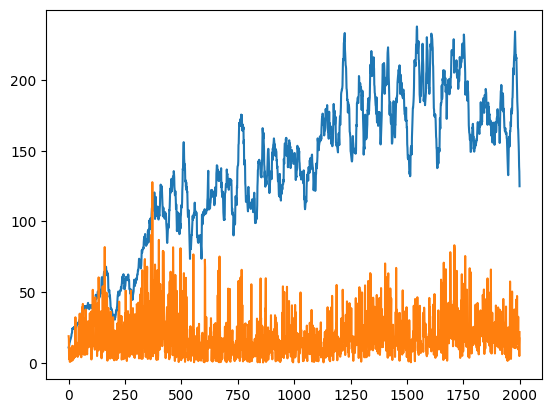

In [64]:
agent.plot()

In [65]:
env = gym.make("CartPole-v1", render_mode = "rgb_array")
state, _ = env.reset()
done = False
policy_net = agent.policy_net
policy_net.eval()
total_reward = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

while not done:
    with torch.no_grad():
        state = torch.tensor(state).unsqueeze(0).to(device)
        action = torch.argmax(policy_net(state)).item()
    # print(action)
    next_state, reward, term, trun, _  = env.step(action)
    total_reward += reward
    done = term or trun
    state = next_state
    # time.sleep(0.1)
print(total_reward)

154.0
